# 0. About

This notebook is to test when facing non-linear correlation in the datasets, if kernel CCA would handle it better.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import warnings

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression
# from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.utils import Bunch

from cca_zoo.models import CCA as cz_CCA
from cca_zoo.models import KCCA as cz_KCCA
from cca_zoo.model_selection import GridSearchCV as cz_GridSearchCV

rs_num = 14
rng = np.random.default_rng(rs_num)

sklearn.set_config(display="diagram")

%matplotlib inline

# 1. Dataset Construction

In [2]:
sample_num = 1000
X_dimension_num = 7
Y_dimension_num = 8

# construct X
X = rng.normal(loc=0.0, scale=1.0, size=(sample_num, X_dimension_num))

# construct noise
xi_1 = rng.normal(loc=0, scale=np.sqrt(0.4), size=(sample_num, ))
xi_2 = rng.normal(loc=0, scale=np.sqrt(0.2), size=(sample_num, ))
xi_3 = rng.normal(loc=0, scale=np.sqrt(0.3), size=(sample_num, ))

# construct Y
Y = rng.normal(loc=0.0, scale=1.0, size=(sample_num, Y_dimension_num))
Y[:, 0] = np.exp(X[:, 2]) + xi_1
Y[:, 1] = np.power(X[:, 0], 3) + xi_2
Y[:, 2] = -X[:, 3] + xi_3

In [3]:
# some numbers for validation
n_splits = 5
n_repeats = 5

In [4]:
# split dataset into training and testing
[X_train, X_test, Y_train, Y_test] = train_test_split(
    X, Y, test_size=0.20, random_state=rs_num
)

# 2. Baseline

In [5]:
baseline_bunch = Bunch()
baseline_bunch.name = 'baseline'

baseline_bunch.pipeline = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('lr', LinearRegression())
    ]
)

baseline_bunch.cv_scores = cross_validate(
    baseline_bunch.pipeline, X_train, Y_train, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
)['test_score']

# also train on the whole training dataset, and see the score on the test dataset
baseline_bunch.pipeline.fit(X_train, Y_train)

# modal evaluation on the test dataset
baseline_bunch.eval_score = baseline_bunch.pipeline.score(X_test, Y_test)

# 3. Linear CCA

In [6]:
# we need to define the scoring method with customized scoring function
# ref: https://github.com/jameschapman19/cca_zoo/issues/150
def scoring_func(estimator, views):
    return np.mean(estimator.score(views))

In [7]:
cca_linear_bunch = Bunch()
cca_linear_bunch.name = 'linear cca'

# grid search for components number (or latent dimensions)
cca_linear_bunch.n_components_arr = np.arange(1, np.min([X_dimension_num, Y_dimension_num])+1)

cca_linear_bunch.best_estimator = cz_GridSearchCV(
    cz_CCA(random_state=rs_num), 
    param_grid={'latent_dims': cca_linear_bunch.n_components_arr}, 
    scoring=scoring_func, 
    cv=RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num)
).fit([X_train, Y_train]).best_estimator_

# also update the name
cca_linear_bunch.name += '\n(n={})'.format(cca_linear_bunch.best_estimator.latent_dims)

Now we can do the cross-validation to see the model performance.

In [8]:
# create a customized cross-validation method
def custom_cv(validator, X, Y, fit_n_score_func, *args):
    # note: normally X and Y are already training datasets
    
    # construct score array
    score_arr = np.zeros((validator.get_n_splits(), ))
    
    # fit and validate
    ii = 0
    for train_ind, test_ind in validator.split(X):
        # slicing arrays
        X_train, X_test = X[train_ind], X[test_ind]
        Y_train, Y_test = Y[train_ind], Y[test_ind]
        
        # train the model and get the score
        score_arr[ii] = fit_n_score_func(X_train, X_test, Y_train, Y_test, *args)
        ii += 1
    
    return score_arr

In [9]:
# create a customized pipeline
def linear_cca_fit_n_score(X_train, X_test, Y_train, Y_test, cz_cca):
    # fitting the model
    cz_cca.fit([X_train, Y_train])
    
    # transform the model
    Xc_train, Yc_train = cz_cca.transform([X_train, Y_train])
    Xc_test, Yc_test = cz_cca.transform([X_test, Y_test])
    
    # train with linear regression and get a score
    return LinearRegression().fit(Xc_train, Yc_train).score(Xc_test, Yc_test)

In [10]:
# cross validation
cca_linear_bunch.cv_scores = custom_cv(
    RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num), 
    X_train, Y_train, 
    linear_cca_fit_n_score, 
    cca_linear_bunch.best_estimator
)

# also evaluate the model via test dataset
cca_linear_bunch.eval_score = linear_cca_fit_n_score(
    X_train, X_test, Y_train, Y_test, 
    cca_linear_bunch.best_estimator
)

# 4. Kernel CCA

For kernel selections: https://scikit-learn.org/stable/modules/metrics.html

You can also use customized kernel function.


In [11]:
kcca_bunch = Bunch()
kcca_bunch.name = 'kernel cca'

kcca_bunch.n_components_arr = np.arange(1, np.min([X_dimension_num, Y_dimension_num])+1)
kcca_bunch.gamma1_list = [3*i for i in np.logspace(-2, 1, 3)] # variance
kcca_bunch.gamma2_list = [3*i for i in np.logspace(-2, 1, 3)] # variance
kcca_bunch.c1_list = [0.95*i for i in np.logspace(-2, 0, 3)] # regularization
kcca_bunch.c2_list = [0.95*i for i in np.logspace(-2, 0, 3)] # regularization
kcca_bunch.param_grid = {
    'kernel': ['rbf', 'linear'], 
    'latent_dims': kcca_bunch.n_components_arr, 
    'gamma': [kcca_bunch.gamma1_list, kcca_bunch.gamma2_list], 
    'c': [kcca_bunch.c1_list, kcca_bunch.c2_list]
}

# fitting and searching
kcca_bunch.best_estimator = cz_GridSearchCV(
    cz_KCCA(kernel='rbf', random_state=rs_num), 
    param_grid=kcca_bunch.param_grid, 
    scoring=scoring_func, 
    cv=RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num)
).fit([X_train, Y_train]).best_estimator_

In [12]:
# create a customized pipeline
def kernel_cca_fit_n_score(X_train, X_test, Y_train, Y_test, cz_kcca):
    # fitting the model
    cz_kcca.fit([X_train, Y_train])
    
    # transform the model
    Xc_train, Yc_train = cz_kcca.transform([X_train, Y_train])
    Xc_test, Yc_test = cz_kcca.transform([X_test, Y_test])
    
    # train with linear regression and get a score
    return LinearRegression().fit(Xc_train, Yc_train).score(Xc_test, Yc_test)

In [13]:
# cross validation
kcca_bunch.cv_scores = custom_cv(
    RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num), 
    X_train, Y_train, 
    kernel_cca_fit_n_score, 
    kcca_bunch.best_estimator, 
)

# also evaluate the model via test dataset
kcca_bunch.eval_score = kernel_cca_fit_n_score(
    X_train, X_test, Y_train, Y_test, 
    kcca_bunch.best_estimator
)

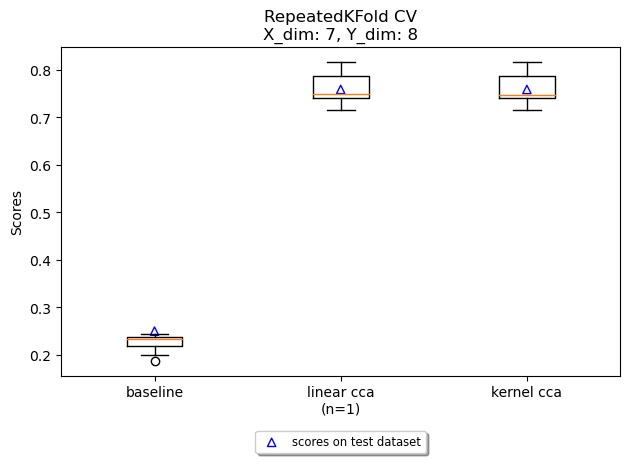

In [14]:
# put everything in one list
bunch_list_all = [
    baseline_bunch, 
    cca_linear_bunch, 
    kcca_bunch
]

# visualize model evaluation
viz_labels = []
viz_boxplots = []
viz_eval_scores = []
viz_eval_scores_pos = []

for i, bunch in enumerate(bunch_list_all):
    viz_labels.append(bunch.name)
    viz_boxplots.append(bunch.cv_scores)
    viz_eval_scores.append(bunch.eval_score)
    viz_eval_scores_pos.append(i+1)

# visualization
fig, ax = plt.subplots()

ax.boxplot(
    viz_boxplots, 
    labels=viz_labels
)
ax.scatter(
    viz_eval_scores_pos, 
    viz_eval_scores,  
    fc='none',
    ec='blue', 
    marker='^', 
    label='scores on test dataset'
)

ax.set(
    ylabel='Scores', 
    title='RepeatedKFold CV\n'+'X_dim: {}, Y_dim: {}'.format(
        X_dimension_num, Y_dimension_num
    )
)
ax.set_xticklabels(viz_labels, rotation=0)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    ncol=2,
    fontsize='small'
)

plt.tight_layout()

In [15]:
kcca_bunch.best_estimator_df = pd.DataFrame(index=['X', 'Y'])
kcca_bunch.best_estimator_df['kernels'] = kcca_bunch.best_estimator.kernel
kcca_bunch.best_estimator_df['reg c'] = kcca_bunch.best_estimator.c
kcca_bunch.best_estimator_df['gamma'] = kcca_bunch.best_estimator.gamma

print('with parameters:')
print(kcca_bunch.best_estimator.get_params())

with parameters:
{'c': [0.0095, 0.0095], 'centre': True, 'coef0': [1, 1], 'copy_data': True, 'degree': [1, 1], 'eps': 0.001, 'gamma': [0.03, 0.03], 'kernel': ['linear', 'linear'], 'kernel_params': None, 'latent_dims': 1, 'random_state': RandomState(MT19937) at 0x18EAA0D6A40, 'scale': True}
